Parameters saved to diffusion-output/stable-diffusion-1-5_4-images_50-steps_15000-inference/parameters.json
Using device: mps


Loading Stable Diffusion model:   0%|          | 0/1 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading and preprocessing images:   0%|          | 0/4 [00:00<?, ?it/s]

Processed sizes: [(256, 256), (256, 256), (256, 256), (256, 256)]
Original sizes: [(256, 256), (256, 256), (256, 256), (256, 256)]


Encoding images to latent representations:   0%|          | 0/4 [00:00<?, ?it/s]

Shapes of latents: [torch.Size([1, 4, 32, 32]), torch.Size([1, 4, 32, 32]), torch.Size([1, 4, 32, 32]), torch.Size([1, 4, 32, 32])]
Interpolating between latents...


Interpolating and Decoding:   0%|          | 0/50 [00:00<?, ?it/s]

Interpolation complete. 50 images generated and saved in diffusion-output/stable-diffusion-1-5_4-images_50-steps_15000-inference
Plotting results...


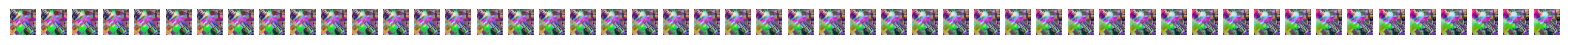

Plot saved to diffusion-output/stable-diffusion-1-5_4-images_50-steps_15000-inference/interpolation_steps.png


In [10]:
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from diffusers import StableDiffusionPipeline, DDIMScheduler
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from transformers import CLIPImageProcessor
import json

# Parameters
model_id = "Jiali/stable-diffusion-1.5"
image_paths = [
    "../data/results/ma-boston_200250_fake_B.png",
    "../data/results/nc-charlotte_200250_fake_B.png",
    "../data/results/ny-manhattan_200250_fake_B.png",
    "../data/results/pa-pittsburgh_200250_fake_B.png"
]
num_steps = 50 # increase for smoother interpolation
inference_steps = 15000 # increase for better image quality
identifier = f"stable-diffusion-1-5_4-images_{num_steps}-steps_{inference_steps}-inference"  # Unique identifier for this run
output_dir = os.path.join("diffusion-output", identifier)
output_image_size = (512, 512)  # width and height of output image
max_image_dimension = 1024  # Maximum dimension for resizing images, previously at 768

# Create a dictionary with all relevant parameters
params = {
    "identifier": identifier,
    "model_id": model_id,
    "num_steps": num_steps,
    "inference_steps": inference_steps,
    "output_image_size": output_image_size,
    "max_image_dimension": max_image_dimension
}

# Define the path to save the JSON file
params_path = os.path.join(output_dir, "parameters.json")

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Save the parameters to a JSON file
with open(params_path, 'w') as f:
    json.dump(params, f, indent=4)

print(f"Parameters saved to {params_path}")

# Set device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

def slerp(val, low, high):
    """Spherical linear interpolation for 4D tensors."""
    low_2d = low.view(low.shape[0], -1)
    high_2d = high.view(high.shape[0], -1)
    low_2d_norm = low_2d / torch.norm(low_2d, dim=1, keepdim=True)
    high_2d_norm = high_2d / torch.norm(high_2d, dim=1, keepdim=True)
    omega = torch.acos((low_2d_norm * high_2d_norm).sum(1).clamp(-1, 1))
    so = torch.sin(omega)
    res = (torch.sin((1.0 - val) * omega) / so).unsqueeze(1) * low_2d + \
          (torch.sin(val * omega) / so).unsqueeze(1) * high_2d
    return res.view(low.shape)

def load_and_preprocess_image(image_path):
    # Open the image and convert to RGB
    image = Image.open(image_path).convert("RGB")
    
    # Get the original size
    original_size = image.size
    
    # Calculate the aspect ratio
    aspect_ratio = original_size[0] / original_size[1]
    
    # Determine the new size (ensuring it's divisible by 8 for the VAE)
    if aspect_ratio > 1:
        new_width = min(original_size[0], max_image_dimension)
        new_width = new_width - (new_width % 8)
        new_height = int(new_width / aspect_ratio)
        new_height = new_height - (new_height % 8)
    else:
        new_height = min(original_size[1], max_image_dimension)
        new_height = new_height - (new_height % 8)
        new_width = int(new_height * aspect_ratio)
        new_width = new_width - (new_width % 8)
    
    new_size = (new_width, new_height)
    
    # Create the transform
    transform = Compose([
        Resize(new_size),
        ToTensor(),
        Normalize([0.5], [0.5])
    ])
    
    # Apply the transform
    image_tensor = transform(image).unsqueeze(0).to(device).to(torch.float16)  # Ensure consistent data type
    
    return image_tensor, new_size, original_size

try:
    # Load the pre-trained Stable Diffusion model with DDIM scheduler
    with tqdm(total=1, desc="Loading Stable Diffusion model") as pbar:
        scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")
        pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)  # Use mixed precision
        pipe = pipe.to(device)
        if device.type == "cuda":
            pipe.enable_attention_slicing()
        pbar.update(1)

    # Load and preprocess images
    images = []
    sizes = []
    original_sizes = []
    with tqdm(total=len(image_paths), desc="Loading and preprocessing images") as pbar:
        for image_path in image_paths:
            image, size, original_size = load_and_preprocess_image(image_path)
            images.append(image)
            sizes.append(size)
            original_sizes.append(original_size)
            pbar.update(1)

    print(f"Processed sizes: {sizes}")
    print(f"Original sizes: {original_sizes}")

    # Encode images to latents
    latents = []
    with tqdm(total=len(images), desc="Encoding images to latent representations") as pbar:
        with torch.no_grad():
            for image in images:
                latent = pipe.vae.encode(image).latent_dist.sample() * 0.18215
                latents.append(latent)
                pbar.update(1)

    print(f"Shapes of latents: {[latent.shape for latent in latents]}")

    # Interpolate between latents
    print("Interpolating between latents...")
    alphas = np.linspace(0, 1, num_steps)
    interpolated_images = []
    
    with tqdm(total=num_steps, desc="Interpolating and Decoding") as pbar:
        for alpha in alphas:
            # Interpolate between the first and last latent
            interpolated_latent = slerp(alpha, latents[0], latents[-1])
            with torch.no_grad():
                # Scale the latents
                interpolated_latent = 1 / 0.18215 * interpolated_latent
                # Decode the latents
                decoded_image = pipe.vae.decode(interpolated_latent).sample
                # Normalize the decoded image
                decoded_image = (decoded_image / 2 + 0.5).clamp(0, 1)
                # Convert to CPU and then to numpy array
                decoded_image = decoded_image.cpu().permute(0, 2, 3, 1).numpy()[0]
            
            # Convert to PIL Image
            decoded_image_pil = Image.fromarray((decoded_image * 255).astype(np.uint8))
            # Resize the output image to the desired output size
            decoded_image_pil = decoded_image_pil.resize(output_image_size, Image.LANCZOS)
            
            interpolated_images.append(decoded_image_pil)
            
            # Save the interpolated image
            os.makedirs(output_dir, exist_ok=True)
            output_path = os.path.join(output_dir, f"interpolated_{len(interpolated_images)}.png")
            decoded_image_pil.save(output_path, quality=95)
            
            pbar.update(1)

    print(f"Interpolation complete. {num_steps} images generated and saved in {output_dir}")

    # Plot results and save the plot as an image file
    print("Plotting results...")
    fig, axes = plt.subplots(1, num_steps, figsize=(20, 4))
    for ax, img in zip(axes, interpolated_images):
        ax.imshow(img)
        ax.axis('off')
    
    # Save the plot to a file
    plot_path = os.path.join(output_dir, "interpolation_steps.png")
    fig.savefig(plot_path, bbox_inches='tight')
    plt.show()
    print(f"Plot saved to {plot_path}")

except Exception as e:
    print(f"An error occurred: {e}")